In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
sns.set(style="whitegrid")

pd.set_option('display.max_columns', 50)

In [24]:
#Importación de los datos, contactos y transacciones
df_tr = pd.read_csv('./Transactions_cognifitId.csv', encoding = 'ISO-8859-1')
df_cont = pd.read_csv('./contacts_with_transactions_01012017.csv', encoding = 'ISO-8859-1')

#Para el DF de transacciones, se eliminan aquellas que no dispongan del tipo de transacción o el Cognifit user Id
#Se convierte el Cognifit User Id en INT
#Se convierte en objetos datetime la serie Transaction Date
#Se crea el campo Transaction Month para obtener cada mes
df_tr = df_tr.dropna(subset=['Transaction Type','Contact: Cognift User ID'])
df_tr['Contact: Cognift User ID']= df_tr['Contact: Cognift User ID'].astype(int)
df_tr['Transaction Date'] = pd.to_datetime(df_tr['Transaction Date'])
df_tr['Transaction Month'] = df_tr['Transaction Date'].dt.strftime('%B')

#Para el DF de contactos con transacciones, eliminamos duplicados en base al Cognifit User Id y aquellos cuyo valor es
#nulo, y se convierte en tipo INT.
df_cont = df_cont.drop_duplicates(subset='Cognift User ID', keep="first")
df_cont = df_cont.dropna(subset=['Cognift User ID'])
df_cont['Created At'] = pd.to_datetime(df_cont['Created At'])
df_cont['Cognift User ID']= df_cont['Cognift User ID'].astype(int)

In [3]:
#Vista inicial de los datos
print(df_tr.shape)
display(df_tr.head())
print(df_cont.shape)
display(df_cont.head())

(44265, 18)


,Transaction Date,Contact: Age,Quantity,Final Price,Internal Code,Element Table,Transaction Type,Contact: User Type,User Professional,Platform,Contact: Country Location,Contact: Created At,Contact: Last seen On Android,Contact: Last Seen on iOS,Contact: Last Seen On Web,Contact: Payment Status,Contact: Cognift User ID,Transaction Month
0,2019-10-13 22:37:00,32.0,1,46.56,2019-10-13 22:37:22_4249_IPHONE,t_subscription,GENERAL_YEAR,NORMAL_USER,NORMAL_USER,iOS,Mexico,10/13/2019 10:21 PM,NaN,10/16/2019 3:18 AM,NaN,NaN,2526232,October
1,2017-04-04 00:35:00,30.0,1,19.99,2017-04-040035084522_phone_Renew,t_subscription,PLUS_MONTH,NORMAL_USER,NORMAL_USER,iOS,United States,2/24/2017 10:17 PM,NaN,NaN,NaN,NaN,1263492,April
3,2019-09-11 05:56:00,59.0,1,22.05,2019-09-110556398391,t_subscription,ONE_MONTH,NORMAL_USER,NORMAL_USER,WEB,Austria,9/2/2019 5:28 PM,NaN,NaN,10/17/2019 9:50 AM,NaN,2455808,September
4,2017-04-04 01:10:00,14.0,1,19.95,in_1A4fCa2THcmd2P0dqogxnyf5_Renew,t_subscription,PLUS_MONTH,NORMAL_USER,NORMAL_USER,WEB,United States,5/20/2016 4:15 AM,NaN,NaN,NaN,NaN,1119878,April
5,2018-07-22 21:01:00,48.0,1,19.95,in_1Cqnjl2THcmd2P0d1QX1lx3w_Renew,t_subscription,PLUS_MONTH,NORMAL_USER,NORMAL_USER,WEB,United States,4/23/2018 2:37 AM,NaN,NaN,NaN,NaN,1689152,July


(11564, 5)


,Cognift User ID,Full Name,Created At,Transaction Date,User Type
0,2526232,Fany Campos,10/13/2019 10:21 PM,10/13/2019 10:37 PM,NORMAL_USER
1,2455808,Gerda Pawelka,9/2/2019 5:28 PM,9/11/2019 5:56 AM,NORMAL_USER
2,2373980,Austin Brooks,7/10/2019 8:16 PM,10/14/2019 12:37 AM,NORMAL_USER
3,2419493,Susie M,8/11/2019 1:17 AM,10/14/2019 12:37 AM,NORMAL_USER
4,2082507,Carreon Alberto,1/22/2019 4:05 AM,10/14/2019 12:05 AM,NORMAL_USER


In [4]:
df_tr['Transaction Date'] = pd.to_datetime(df_tr['Transaction Date'])

In [ ]:
#Definición de la función para la obtención de la fecha de expiración de validez de cada transacción.
def get_expiry_date(transaction, date):
    unit = None
    qty = None
    if 'month' in transaction.lower():
        unit = 1
    elif 'year'in transaction.lower():
        unit = 12
    if 'two' in transaction.lower():
        qty = 2
    elif 'three' in transaction.lower():
        qty = 3
    else:
        qty = 1
    if unit and qty:
        return (date + pd.DateOffset(months=(unit * qty)))
    else:
        return date 

In [100]:
#Definición de la función para la obtención de la serie de fechas sobre las que obtener el estado de los usuarios:
# Versión: PRINCIPIO - FIN DE MES
def get_period_initial_end_dates(year, months):
    dates = []
    initial_date = datetime.datetime.strptime('01/01/{} 00:00:00'.format(year), '%d/%m/%Y %H:%M:%S')
    #initial_date = datetime.datetime('2019-01-01 00:00:00')
    dates.append(initial_date + pd.DateOffset(months=0))
    for i in range (1, months*2):
        if i%2==0:
            dates.append(pd.to_datetime(dates[i-2] + pd.DateOffset(months=1)))
        else:
            if dates[i-1].month != 2:
                dates.append(pd.to_datetime(dates[i-1] + pd.DateOffset(days=30)))
            else:
                dates.append(pd.to_datetime(dates[i-1] + pd.DateOffset(days=27)))
    return dates

#Definición de la función para la obtención de la serie de fechas sobre las que obtener el estado de los usuarios:
# Versión: FIN DE MES

def get_period_dates(year, months):
    dates = []
    initial_date = datetime.datetime.strptime('01/01/{} 00:00:00'.format(year), '%d/%m/%Y %H:%M:%S')
    #initial_date = datetime.datetime('2019-01-01 00:00:00')
    dates.append(initial_date + pd.DateOffset(months=0))
    for i in range (1, months):
            dates.append(pd.to_datetime(dates[i-1] + pd.DateOffset(months=1)))
    return dates

def get_period_datesV2(year, months):
    dates = {"Month_initial_day": [], "Month_end_day": []}
    initial_date = datetime.datetime.strptime('01/01/{} 00:00:00'.format(year), '%d/%m/%Y %H:%M:%S')
    #initial_date = datetime.datetime('2019-01-01 00:00:00')
    dates['Month_initial_day'].append(initial_date + pd.DateOffset(months=0))
    for i in range (1, months):
      dates['Month_initial_day'].append(dates['Month_initial_day'][i-1] + pd.DateOffset(months=1))
    endDates = pd.Series(dates['Month_initial_day']) + pd.offsets.MonthEnd(0)
    for date in endDates:
        date = date + pd.DateOffset(hours=23, minutes=59, seconds = 59)
    dates['Month_end_day'] = pd.to_datetime(endDates)
    return dates

In [98]:
dates_B = get_period_datesV2(2018, 12)

In [99]:
dates_B

{'Month_initial_day': [Timestamp('2018-01-01 00:00:00'),
  Timestamp('2018-02-01 00:00:00'),
  Timestamp('2018-03-01 00:00:00'),
  Timestamp('2018-04-01 00:00:00'),
  Timestamp('2018-05-01 00:00:00'),
  Timestamp('2018-06-01 00:00:00'),
  Timestamp('2018-07-01 00:00:00'),
  Timestamp('2018-08-01 00:00:00'),
  Timestamp('2018-09-01 00:00:00'),
  Timestamp('2018-10-01 00:00:00'),
  Timestamp('2018-11-01 00:00:00'),
  Timestamp('2018-12-01 00:00:00')],
 'Month_end_day': 0    2018-01-31
 1    2018-02-28
 2    2018-03-31
 3    2018-04-30
 4    2018-05-31
 5    2018-06-30
 6    2018-07-31
 7    2018-08-31
 8    2018-09-30
 9    2018-10-31
 10   2018-11-30
 11   2018-12-31
 dtype: datetime64[ns]}

# NORMAL USERS

In [25]:
#Filtramos el DF de transacciones y el de contactos para que contengan aquellos cuyo usuarios es normal.
df_tr_nrm = df_tr[(df_tr['User Professional'] == 'NORMAL_USER')]
df_cont_nrm = df_cont[(df_cont['User Type'] == 'NORMAL_USER')]

In [39]:
#Creación del campo Expiration Date para obtener la fecha de fin de validez de cada transacción.
df_tr_nrm.loc[:, 'Expiration Date'] = df_tr_nrm.loc[:].apply(lambda row: get_expiry_date(row['Transaction Type'], row['Transaction Date']), axis = 1)
df_tr_nrm = df_tr_nrm[(df_tr_nrm['Transaction Date'] != df_tr_nrm['Expiration Date'])]
#Method 2 (Métodos alternativos para aplicar la fórmula anterior)
#for index, row in df_tr_test.iterrows():
    #df_tr_test.loc[index, 'Expiry Date'] = get_expiry_date(df_tr_test.loc[index, 'Transaction Type'], df_tr_test.loc[index, 'Transaction Date'])
#Method 3
#for index, row in df_tr_test.iterrows():
    #row['Expiry Date'] = get_expiry_date(row['Transaction Type'], row['Transaction Date'])

In [40]:
#df_tr_nrm[['Transaction Type', 'Transaction Date', 'Expiration Date']].head(10)
df_tr_nrm[(df_tr_nrm['Transaction Date'] == df_tr_nrm['Expiration Date'])].shape

(0, 19)

In [193]:
dates_df = pd.DataFrame(pd.to_datetime(get_period_dates(2017, 31)), columns = ['Date'])

In [194]:
dates_df['Date'] = pd.to_datetime(dates_df['Date'])

In [195]:
dates_df

,Date
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
5,2017-06-01
6,2017-07-01
7,2017-08-01
8,2017-09-01
9,2017-10-01


In [196]:
dates_df['End_Date'] = dates_df['Date'] + pd.offsets.MonthEnd(0) 
dates_df['End_Date'] = dates_df['End_Date'].apply(lambda x: x + pd.DateOffset(hours=23, minutes=59, seconds=59))

In [197]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [202]:
product = cartesian_product_basic(dates_df, df_cont_nrm)
product = product[(product['Date']>=product['Created At'])].reset_index()

In [203]:
product.head(90)

,index,Date,End_Date,Cognift User ID,Full Name,Created At,Transaction Date,User Type
0,9658,2017-02-01,2017-02-28 23:59:59,1237860,Magdalena Navarro Santolaria,2017-01-18 19:08:00,9/6/2019 10:38 AM,NORMAL_USER
1,9819,2017-02-01,2017-02-28 23:59:59,1231525,Alana,2017-01-08 06:08:00,1/11/2017 1:09 AM,NORMAL_USER
2,9820,2017-02-01,2017-02-28 23:59:59,1231742,Gouzel,2017-01-08 22:37:00,1/12/2017 1:05 AM,NORMAL_USER
3,9821,2017-02-01,2017-02-28 23:59:59,1233920,Alicia Reyes,2017-01-12 08:46:00,1/12/2017 1:10 AM,NORMAL_USER
4,9822,2017-02-01,2017-02-28 23:59:59,1233995,Murray Dublonko,2017-01-12 14:20:00,1/12/2017 6:31 AM,NORMAL_USER
5,9823,2017-02-01,2017-02-28 23:59:59,1229763,Diana Rehaluk,2017-01-05 09:40:00,1/5/2017 7:56 PM,NORMAL_USER
6,9824,2017-02-01,2017-02-28 23:59:59,1227639,?????????,2017-01-02 11:43:00,1/6/2017 1:09 AM,NORMAL_USER
7,9825,2017-02-01,2017-02-28 23:59:59,1228646,Brooke,2017-01-03 23:49:00,1/7/2017 4:35 PM,NORMAL_USER
8,9826,2017-02-01,2017-02-28 23:59:59,1228595,Isabelle,2017-01-03 22:58:00,1/7/2017 4:35 PM,NORMAL_USER
9,9827,2017-02-01,2017-02-28 23:59:59,1231558,Judith Schmania,2017-01-07 23:30:00,1/7/2017 11:39 PM,NORMAL_USER


In [204]:
product.dropna(subset = ['Date', 'Cognift User ID'], inplace = True)

In [205]:
#table = pd.pivot_table(df, values=['D', 'E'], index=['A', 'C'], aggfunc={'D': np.mean, 'E': np.mean})
df_tr_pivot = pd.pivot_table(df_tr_nrm, values=['Transaction Date', 'Expiration Date'],
                             index=['Contact: Cognift User ID'],
                             aggfunc={'Transaction Date': np.min, 'Expiration Date': np.max}).reset_index()

In [206]:
df_tr_pivot

,Contact: Cognift User ID,Expiration Date,Transaction Date
0,25042,2017-11-04 18:47:00,2017-10-04 18:47:00
1,25130,2019-11-25 18:18:00,2017-11-25 17:12:00
2,25217,2019-11-18 01:13:00,2017-01-18 01:09:00
3,25243,2017-11-19 15:30:00,2017-10-19 15:27:00
4,25430,2020-03-31 18:32:00,2017-05-18 14:09:00
5,25568,2019-11-23 12:08:00,2018-11-23 12:08:00
6,25916,2019-11-23 23:23:00,2017-11-23 22:21:00
7,25959,2020-08-01 10:13:00,2017-01-05 01:12:00
8,26257,2018-05-31 01:07:00,2017-05-31 01:07:00
9,26408,2018-11-15 01:17:00,2017-11-15 01:17:00


In [207]:
df_tr_nrm['Transaction Date'].dtype

dtype('<M8[ns]')

In [208]:
df_tr_nrm['Expiration Date'].dtype

dtype('<M8[ns]')

In [209]:
product['Date'].dtype

dtype('<M8[ns]')

In [210]:
product['End_Date'].dtype

dtype('<M8[ns]')

In [139]:
def label_user_status_detail(date, endDate, cognifitId):
    #Es churn?
    if (len(df_tr_nrm[(df_tr_nrm['Expiration Date'] >= date) & (df_tr_nrm['Expiration Date'] < endDate)])>0) and len(df_tr_nrm[(df_tr_nrm['Transaction Date'] >= date) & (df_tr_nrm['Transaction Date'] <= endDate)])==0:
        return 'Churn'
    elif (len(df_tr_nrm[(df_tr_nrm['Transaction Date'] >= date) & (df_tr_nrm['Expiration Date'] > endDate)])>0) and len(df_tr_nrm[(df_tr_nrm['Transaction Date'] < date)])==0:
        return 'New'
    elif (len(df_tr_nrm[(df_tr_nrm['Transaction Date'] < date)])>0) and len(df_tr_nrm[(df_tr_nrm['Expiration Date'] >= endDate)])==0:
        return 'Active'
    else:
        return 'Inactive'

In [140]:
product['User_Status'] = product.head(1000).apply(lambda row: label_user_status(row['Date'], row['End_Date'], row['Cognift User ID']), axis = 1)

In [141]:
product['User_Status'].unique()

array(['Inactive', nan], dtype=object)

In [174]:
def label_user_status_fast(date, endDate, cognifitId):
    row = df_tr_pivot[df_tr_pivot['Contact: Cognift User ID']==cognifitId]
    try:
        exp_date = pd.to_datetime(row['Expiration Date'].item())
        tran_date = pd.to_datetime(row['Transaction Date'].item())
        if (exp_date > date) and (exp_date < endDate):
            return 'Churn'
        elif (tran_date >= date) and (tran_date <= endDate):
            return 'New'
        elif (tran_date < date) and exp_date > endDate:
            return 'Active'
        else:
            return 'Inactive'
    except:
        return('Puntual transactions')

In [211]:
product['User_Status'] = product.apply(lambda row: label_user_status_fast(row['Date'], row['End_Date'], row['Cognift User ID']), axis = 1)

In [217]:
product

,index,Date,End_Date,Cognift User ID,Full Name,Created At,Transaction Date,User Type,User_Status
0,9658,2017-02-01,2017-02-28 23:59:59,1237860,Magdalena Navarro Santolaria,2017-01-18 19:08:00,9/6/2019 10:38 AM,NORMAL_USER,Inactive
1,9819,2017-02-01,2017-02-28 23:59:59,1231525,Alana,2017-01-08 06:08:00,1/11/2017 1:09 AM,NORMAL_USER,Active
2,9820,2017-02-01,2017-02-28 23:59:59,1231742,Gouzel,2017-01-08 22:37:00,1/12/2017 1:05 AM,NORMAL_USER,Churn
3,9821,2017-02-01,2017-02-28 23:59:59,1233920,Alicia Reyes,2017-01-12 08:46:00,1/12/2017 1:10 AM,NORMAL_USER,Churn
4,9822,2017-02-01,2017-02-28 23:59:59,1233995,Murray Dublonko,2017-01-12 14:20:00,1/12/2017 6:31 AM,NORMAL_USER,Active
5,9823,2017-02-01,2017-02-28 23:59:59,1229763,Diana Rehaluk,2017-01-05 09:40:00,1/5/2017 7:56 PM,NORMAL_USER,Churn
6,9824,2017-02-01,2017-02-28 23:59:59,1227639,?????????,2017-01-02 11:43:00,1/6/2017 1:09 AM,NORMAL_USER,Active
7,9825,2017-02-01,2017-02-28 23:59:59,1228646,Brooke,2017-01-03 23:49:00,1/7/2017 4:35 PM,NORMAL_USER,Churn
8,9826,2017-02-01,2017-02-28 23:59:59,1228595,Isabelle,2017-01-03 22:58:00,1/7/2017 4:35 PM,NORMAL_USER,Churn
9,9827,2017-02-01,2017-02-28 23:59:59,1231558,Judith Schmania,2017-01-07 23:30:00,1/7/2017 11:39 PM,NORMAL_USER,Active


In [218]:
product = product[['Date', 'User_Status']]

In [219]:
product_pivot = pd.pivot_table(product, index=['Date'], columns=['User_Status'], aggfunc=len, fill_value=0)

#table = pd.pivot_table(df, values='D', index=['A', 'B'], columns=['C'], aggfunc=np.sum)

In [220]:
product_pivot

User_Status,Active,Churn,Inactive,New,Puntual transactions
Date,,,,,
2017-02-01,37,18,18,8,4
2017-03-01,69,32,49,21,5
2017-04-01,141,45,100,20,12
2017-05-01,176,50,163,20,22
2017-06-01,223,65,234,17,36
2017-07-01,280,70,322,22,48
2017-08-01,316,82,422,16,57
2017-09-01,402,82,544,22,81
2017-10-01,492,71,643,37,102


In [221]:
def get_churn_ratio(active, new, churn):
    return (churn/(active + new) * 100)

In [222]:
product_pivot['Churn ratio'] =  product_pivot.apply(lambda row: get_churn_ratio(row['Active'],row['New'], row['Churn']), axis=1)

In [223]:
product_pivot

User_Status,Active,Churn,Inactive,New,Puntual transactions,Churn ratio
Date,,,,,,
2017-02-01,37,18,18,8,4,40.000000
2017-03-01,69,32,49,21,5,35.555556
2017-04-01,141,45,100,20,12,27.950311
2017-05-01,176,50,163,20,22,25.510204
2017-06-01,223,65,234,17,36,27.083333
2017-07-01,280,70,322,22,48,23.178808
2017-08-01,316,82,422,16,57,24.698795
2017-09-01,402,82,544,22,81,19.339623
2017-10-01,492,71,643,37,102,13.421550


In [227]:
product_pivot.index = pd.to_datetime(product_pivot.index).to_series().dt.strftime('%m/%d/%Y')

[Text(0, 0, '02/01/2017'),
 Text(0, 0, '03/01/2017'),
 Text(0, 0, '04/01/2017'),
 Text(0, 0, '05/01/2017'),
 Text(0, 0, '06/01/2017'),
 Text(0, 0, '07/01/2017'),
 Text(0, 0, '08/01/2017'),
 Text(0, 0, '09/01/2017'),
 Text(0, 0, '10/01/2017'),
 Text(0, 0, '11/01/2017'),
 Text(0, 0, '12/01/2017'),
 Text(0, 0, '01/01/2018'),
 Text(0, 0, '02/01/2018'),
 Text(0, 0, '03/01/2018'),
 Text(0, 0, '04/01/2018'),
 Text(0, 0, '05/01/2018'),
 Text(0, 0, '06/01/2018'),
 Text(0, 0, '07/01/2018'),
 Text(0, 0, '08/01/2018'),
 Text(0, 0, '09/01/2018'),
 Text(0, 0, '10/01/2018'),
 Text(0, 0, '11/01/2018'),
 Text(0, 0, '12/01/2018'),
 Text(0, 0, '01/01/2019'),
 Text(0, 0, '02/01/2019'),
 Text(0, 0, '03/01/2019'),
 Text(0, 0, '04/01/2019'),
 Text(0, 0, '05/01/2019'),
 Text(0, 0, '06/01/2019'),
 Text(0, 0, '07/01/2019')]

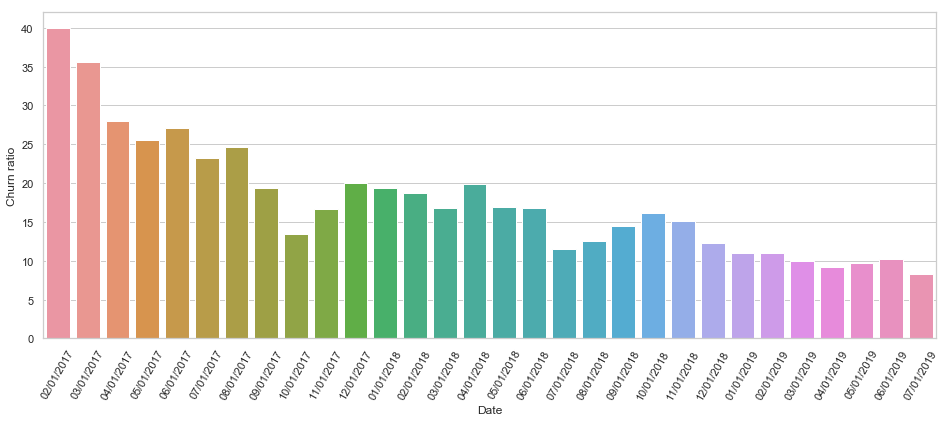

In [229]:
plt.figure(figsize=(16, 6))
valor_plot = sns.barplot(data= product_pivot, x= product_pivot.index, y= 'Churn ratio')
valor_plot.set_xticklabels(valor_plot.get_xticklabels(), rotation=60)